# W.5. Black Scholes and the Greeks

## Financial Analytics

### UChicago ADSP

#### Spring 2024

* Mark Hendricks
* hendricks@uchicago.edu

$\newcommand{\dvd}{D}$
$\newcommand{\pvdvd}{D^*}$
$\newcommand{\pvstrike}{K^*}$
$\newcommand{\strike}{K}$

$\newcommand{\nargcond}{d_{1}}$
$\newcommand{\nargexer}{d_{2}}$

$\newcommand{\EcondS}{\hat{S}_{\text{conditional}}}$
$\newcommand{\probexer}{\hat{\mathcal{P}}_{\text{exercise}}}$

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

import sys
sys.path.insert(0,'../cmds')
from options import *

In [2]:
TICK = 'AMZN'

DATE = pd.to_datetime(datetime.date.today())
EXPRYDATE = '2022-08-26'
tau = to_maturity(expiration=EXPRYDATE,current_date=DATE)

START_DATE = '2022-07-20'
END_DATE = '2022-07-21'

USESOFR = False

In [3]:
import yfinance as yf
import pandas_datareader.data as web
import pandas_datareader as pdr

In [4]:
TICKRF = 'SOFR'
TICKTBILL = '^IRX'

sec = yf.Ticker(TICK)
px = sec.history('1d')['Close'].values[0]

tbill = yf.Ticker(TICKTBILL).history('1d',start=START_DATE,end=END_DATE)['Close'].iloc[-1]/100
sofr = pdr.DataReader(TICKRF,data_source='fred', start=START_DATE,end=END_DATE).iloc[-1].values[0]/100

if USESOFR:
    rf = sofr
else:
    rf = tbill

disc = np.exp(-rf*tau)

In [5]:
opts = sec.option_chain(EXPRYDATE)
calls, puts = clean_options(opts.calls,opts.puts)

base = 5
pxrounded = base * math.floor(px / base)
idCall = (calls['strike'][calls['strike']%5==0] - pxrounded).idxmin()
K = calls.loc[idCall,'strike']

In [6]:
ivolC = calls.loc[idCall,'impliedVolatility']

idPut = puts['strike'].sub(px).abs().idxmin()
ivolP = puts.loc[idPut,'impliedVolatility']

grid_px = np.arange(px/1.5,px*(4/3),.1)

***

# Pricing Options

## Replication Argument

Equity options are a derivative of the underlying stock.
- Thus, option price is a function of the underlying stock, $f(S)$.

Consider the first-order Taylor-series approximation of $f(S)$.
- As we did with bond price as a function of rates.
- For small changes in stock price, a linear approximation will work well.

Thus, the stock and option will be highly correlated.
- In the limit, (instantaneous movements,) they will be perfectly correlated.

Consider the stochastic process for the hedged position, with hedge ratio $\Delta_t$:

$\begin{align}
\Pi_t = f(S_t) - \Delta_t S_t
\end{align}$

- If the hedge ratio $\Delta_t$ is a continuous process, (due to instantaneous rebalancing,) we can set it to keep $\Pi_t$ riskless.

- With no-arbitrage, this riskless hedged portfolio, $\Pi_t$ must have a return equal to the risk-free rate.

Basic stochastic calculus of the proces $\Pi_t$ implies then that 
- the hedge ratio which induces a riskless portfolio is

$\begin{align}
\Delta_t = \frac{\partial f}{\partial S}(S_t)
\end{align}$

The pricing function, $f$, is thus fully characterized by,
- a differential equation which ensures $\Pi_t$ matches the risk-free rate.
- the boundary condition that at expiration $f(S_T)$ equals the contracted option payoff.

## Assumptions

### Free Portfolio Formation
1. Buy and sell any quantity at any time
    - continuous-time trading: possible to rebalance instantaneously
    - divisble: buy or sell any fractional amount
    - unconstrained: no limit to sell short or take a levered position
    
2. Price to buy or sell is same for any quantity.
    - no transaction costs or taxes
    - no margin issues
    - no bid-ask spread or liquidity issues

### Law of One Price
- Any two portfolios (positions) delivering identical payoffs with certainty must have the same price.

- This says that a replicating portfolio must have the same price as its target.

We use the term **frictionless markets** to refer to both these assumptions being satisfied.

### Existence of a riskless investment
Assume that there is a money-market account which earns a constant risk-free rate of $r$.

### No Arbitrage
There are multiple forms of no-arbitrage assumptions. For our purposes:

Any portfolio with a 
- positive probability of a profit
- zero probability of a loss
- must have a strictly positive price.

### Normal distributions

#### The cdf
Let $\mathcal{N}(\cdot)$ denote the c.d.f. of the standard normal distribution. 
- c.d.f. stands for cumulative density funciton
- "standard" refers to a normal distribution with mean 0 and standard deviation 1.

Thus, $\mathcal{N}(x)$ is the probability that a standard normal variable is less than or equal to $x$.

#### The distribution of stock prices
Assume that the stock price, $S_t$ follows a geometric Brownian motion.
- constant mean $\mu$
- constant volatility $\sigma$

This implies that the stock price at time $T$ has a lognormal distribution.

## Black-Scholes-Merton

The price of a European option without dividends is

$\begin{align}
c_t\; =&\; S_t\mathcal{N}(\nargcond) - \pvstrike_t \mathcal{N}\left(\nargexer\right) \\
p_t\; =&\; \pvstrike_t\mathcal{N}\left(-\nargexer\right) - S_t \mathcal{N}(-\nargcond)
\end{align}$

where $\nargcond$ and $\nargexer$ are

$\begin{align}
\nargcond = \frac{\ln\left(\frac{S_t}{\strike}\right) + \left[r + \frac{\sigma^2}{2}\right]T}{\sigma\sqrt{T}} \hspace{1cm} 
\nargexer = \nargcond -\sigma\sqrt{T}
\end{align}$

### Intuition of the $\mathcal{N}(\cdot)$ terms

The normal distribution terms come from...
- assumptions that give the stock price at expiration a normal distribution
- estimating risk-adjusted expected value of the option payoff

See this more easily by rewriting the formula as

$\begin{align}
c_t =& \;  e^{-r\tau}\; \probexer\left[\EcondS - \strike\right]
\end{align}$

where

$\begin{align}
\probexer \equiv & \; \mathcal{N}(\nargexer) \hspace{.5in} 
\EcondS \equiv \; S_t e^{r\tau}\frac{\mathcal{N}(\nargcond)}{\mathcal{N}(\nargexer)}
\end{align}$

are, respectively, the 
- risk-adjusted probability of exercising the option 
- risk-adjusted expectation of the stock price at $T$, conditional on option exercise

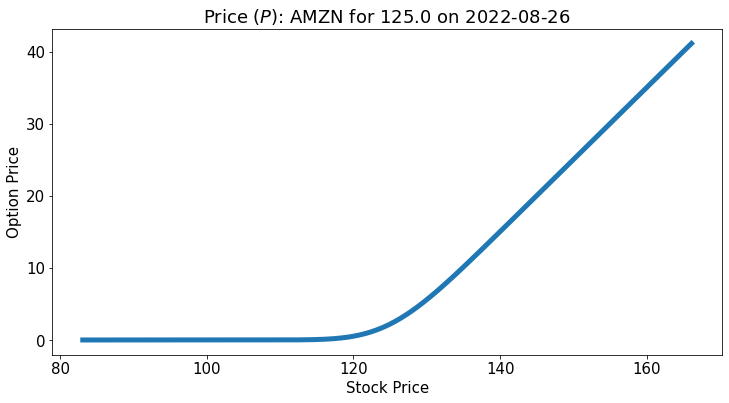

In [7]:
figtitle = f'Price ($P$): {TICK} for {K} on {EXPRYDATE}'

dataplot = pd.Series(index=grid_px,dtype=float)
for spot in grid_px:
    dataplot.loc[spot] = bs_price(under=spot,strike=K,T=tau/10,rf=rf,vol=ivolC)
    
dataplot.plot(ylabel='Option Price',xlabel='Stock Price',title=figtitle,linewidth=5)
plt.show()

In [8]:
grid_tau = np.array([.01,5,21,252])/252
labs_tau = ['now','1w','1m','1y']#,'3m','6m','1y']

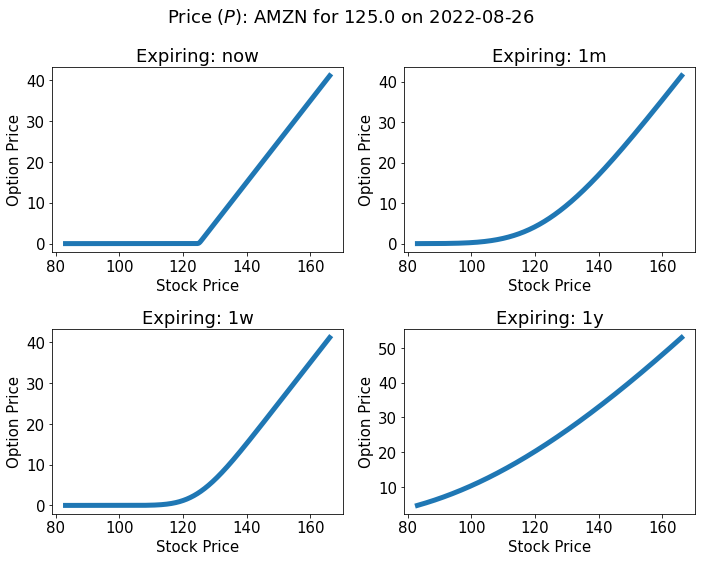

In [9]:
figtitle = f'Price ($P$): {TICK} for {K} on {EXPRYDATE}'

dataplot = pd.DataFrame(index=grid_px,columns=labs_tau, dtype=float)

fig,ax = plt.subplots(2,2,figsize=(10,8))

for idx,t in enumerate(grid_tau):
    
    for spot in grid_px:
        dataplot.loc[spot,labs_tau[idx]] = bs_price(under=spot,strike=K,T=t,rf=rf,vol=ivolC)
    
    dataplot.iloc[:,idx].plot(ax=ax[idx%2,math.floor(idx/2)],ylabel='Option Price',xlabel='Stock Price',title=f'Expiring: {labs_tau[idx]}',linewidth=5)

plt.suptitle(figtitle)
plt.tight_layout()
plt.show()

# Price Sensitivity

## The Greeks

Consider the sensitivity of an option to various factors.
- Certain derivatives are widely referred to by certain Greek letters. 
- These can be calculated as numeric derivatives for American options
- For European options, it is typical to use the Black-Scholes model to get the derivatives in a closed-form solution.

Here we focus on the concept of each derivative rather than the closed-form Black-Scholes solution.

Below, each derivative is written for a portfolio of options, $\Pi$.
- Given the linearity of a derivative,
- The sensitivity of the portfolio is the sum of the individual sensitivities**.


### Delta
An option's delta is the sensitivity to the underlying price.

$$\Delta \equiv \frac{\partial \Pi}{\partial S}$$


Delta is the most important risk factor for an options portfolio.
* Traders typically hedge their delta frequently, particularly for large portfolios.

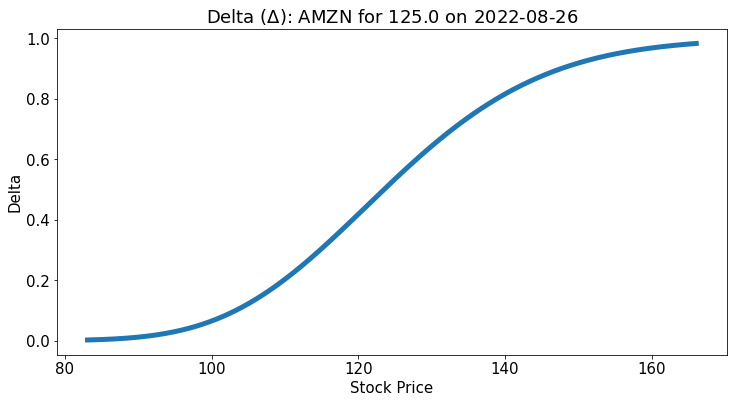

In [10]:
figtitle = f'Delta ($\Delta$): {TICK} for {K} on {EXPRYDATE}'

dataplot = pd.Series(index=grid_px,dtype=float)
for spot in grid_px:
    dataplot.loc[spot] = bs_delta(under=spot,strike=K,T=tau,rf=rf,vol=ivolC)
    
dataplot.plot(ylabel='Delta',xlabel='Stock Price',title=figtitle,linewidth=5)
plt.show()

### Gamma

An option's Gamma is the second derivative with respect to the underlying:
$$\Gamma \equiv \frac{\partial^2 \Pi}{\partial S^2}$$

The Gamma measure's the convexity of the option.

Thus, the Delta and Gamma for an options trader take on a similar role as the duration and convexity for a bond trader. 

Note that Gamma is the sensitivity of Delta to the underlying.
- If Gamma is high, the Delta hedge will need more frequent adjustment

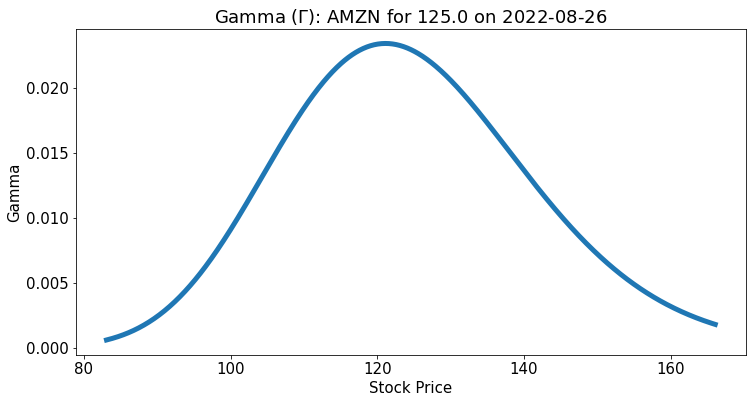

In [11]:
figtitle = f'Gamma ($\Gamma$): {TICK} for {K} on {EXPRYDATE}'

dataplot = pd.Series(index=grid_px,dtype=float)
for spot in grid_px:
    dataplot.loc[spot] = bs_gamma(under=spot,strike=K,T=tau,rf=rf,vol=ivolC)
    
dataplot.plot(ylabel='Gamma',xlabel='Stock Price',title=figtitle,linewidth=5)
plt.show()

## Theta

### Theta Definition

Theta is the sensitivity to passage of time, (decreasing the time-to-expiration.)
$$\Theta \equiv \frac{\partial \Pi}{\partial t}$$

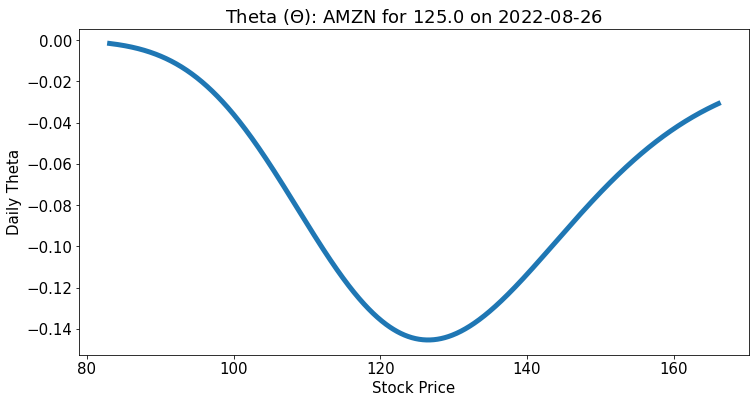

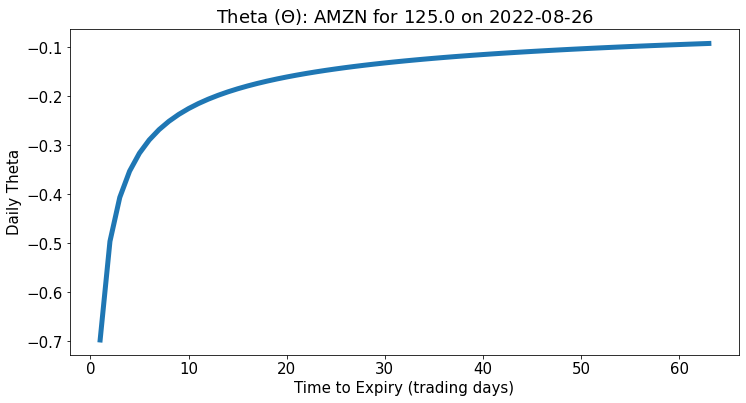

In [12]:
figtitle = f'Theta ($\Theta$): {TICK} for {K} on {EXPRYDATE}'

dataplot = pd.Series(index=grid_px,dtype=float)
for spot in grid_px:
    dataplot.loc[spot] = bs_theta(under=spot,strike=K,T=tau,rf=rf,vol=ivolC)/252
    
dataplot.plot(ylabel='Daily Theta',xlabel='Stock Price',title=figtitle,linewidth=5)
plt.show()

grid_t = np.arange(1/252,.25,1/252)
dataplot = pd.Series(index=grid_t*252,dtype=float)
for t in grid_t:
    dataplot.loc[t*252] = bs_theta(under=px,strike=K,T=t,rf=rf,vol=ivolC)/252
    
dataplot.plot(ylabel='Daily Theta',xlabel='Time to Expiry (trading days)',title=figtitle,linewidth=5)
plt.show()

# Theta-Gamma Tradeoff

## The no-arbitrage math

$$d{\Pi} \approx \Theta dt + \Delta dS + \frac{1}{2}\Gamma (dS)^2$$

The fundamental derivatives pricing equation implies the following equation. (See the appendix for the details.)
$$
r\Pi = \Theta + rS\Delta + \frac{1}{2}\sigma^2 S^2\Gamma
$$

If the portfolio is delta-hedged, then we have
$$
r\Pi = \Theta + \frac{1}{2}\sigma^2 S^2\Gamma
$$

This equation implies that for delta-hedged portfolios, there is a tradeoff between Theta and Gamma.

## An Illustration

Consider AMZN calls for `2022-08-26` as of July 27, 2022.

In [2]:
rf = .02
K = 120
IVOL = .45
S0 = 120

TVAL = 3/52

In [3]:
grid_px = np.arange(S0/1.2,S0*(5/4),.1)
dataplot = pd.DataFrame(grid_px,columns = ['grid'], dtype=float)
idS0 = (dataplot['grid'] - S0).abs().idxmin()
dataplot.set_index('grid',inplace=True)

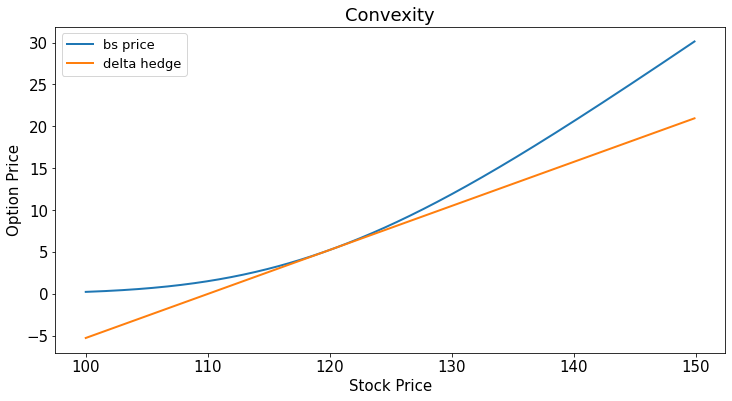

In [4]:
figtitle = f'Convexity'

for spot in grid_px:    
    dataplot.loc[spot,'bs price'] = bs_price(under=spot,strike=K,T=TVAL,rf=rf,vol=IVOL)

beta = bs_delta(under=S0,strike=K,T=TVAL,rf=rf,vol=IVOL)
alpha = dataplot['bs price'].iloc[idS0] - beta * S0
dataplot['delta hedge'] = alpha + beta * grid_px
dataplot.plot(ylabel='Option Price',xlabel='Stock Price',linewidth=2,title=figtitle)
plt.show()

### Hedged Position

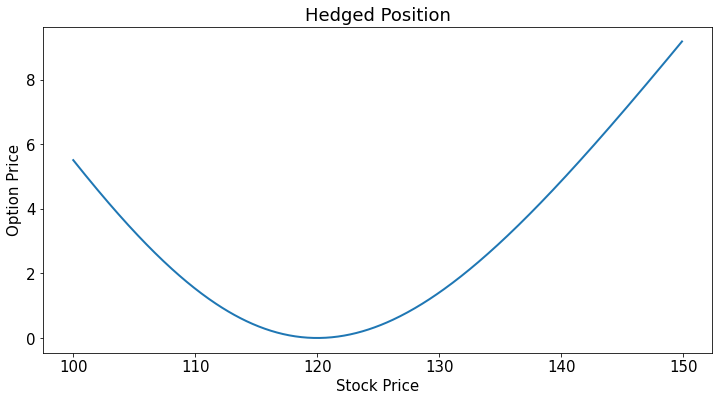

In [14]:
figtitle = 'Hedged Position'

hedged = dataplot.sub(dataplot[['delta hedge']].values,axis=1).drop(columns='delta hedge')
hedged.rename(columns={'bs price':'gross payoff'},inplace=True)
hedged['gross payoff'].plot(ylabel='Option Price',xlabel='Stock Price',linewidth=2,title=figtitle)
plt.show()

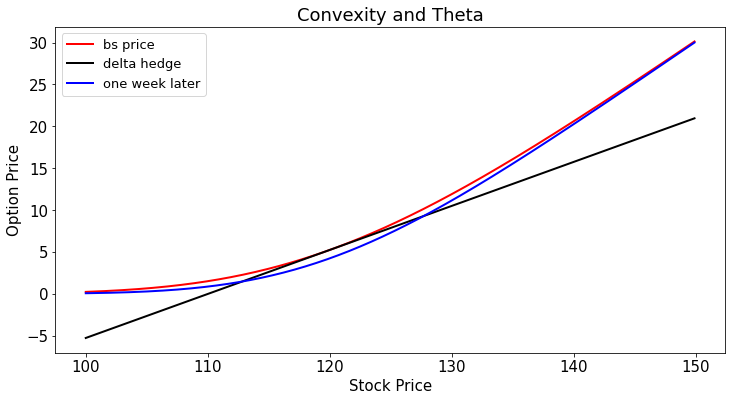

In [6]:
figtitle = 'Convexity and Theta'

Tgrid = [TVAL - 5/252]

for tval in Tgrid:
    for spot in grid_px:
        dataplot.loc[spot,f'one week later'] = bs_price(under=spot,strike=K,T=tval,rf=rf,vol=IVOL)

dataplot.plot(ylabel='Option Price',xlabel='Stock Price',linewidth=2,title=figtitle,color = ['r', 'k','b'])
plt.show()

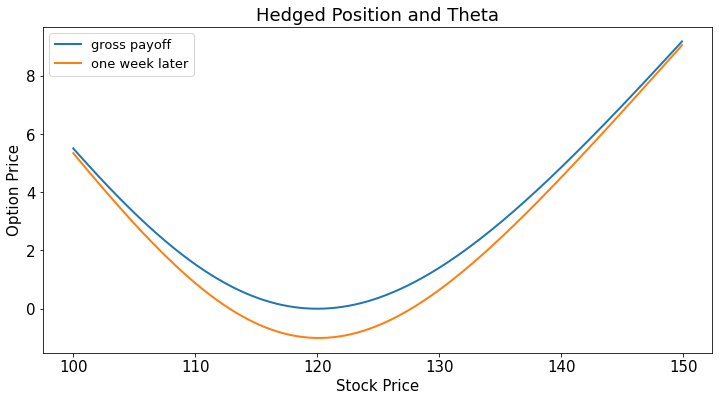

In [15]:
figtitle = 'Hedged Position and Theta'

hedged.plot(ylabel='Option Price',xlabel='Stock Price',linewidth=2,title=figtitle)
plt.show()

# Bounds

In [27]:
# AMZN 2022-08-26 call on July 27, 2022
rf = .05
K = 120
IVOL = .25
S0 = 120

tval = .5

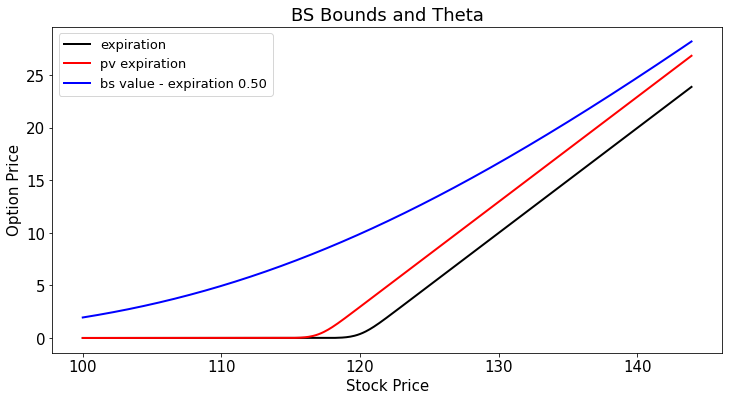

In [28]:
figtitle = 'BS Bounds and Theta'

disc = np.exp(-rf*tval)
grid_px = np.arange(min(S0,K)/1.2,max(S0,K)*1.2,.1)
dataplot_bounds = pd.DataFrame(index=grid_px, dtype=float)
for spot in grid_px:
    dataplot_bounds.loc[spot,f'expiration'] = bs_price(under=spot,strike=K,T=.001,rf=rf,vol=IVOL)
    dataplot_bounds.loc[spot,f'pv expiration'] = bs_price(under=spot,strike=disc * K,T=.001,rf=rf,vol=IVOL)
    
    dataplot_bounds.loc[spot,f'bs value - expiration {tval:.2f}'] = bs_price(under=spot,strike=K,T=tval,rf=rf,vol=IVOL)

dataplot_bounds.plot(ylabel='Option Price',xlabel='Stock Price',linewidth=2,title=figtitle,color=['black','red','blue'])
plt.show()

***

# Other Greeks

### Vega

### Rho


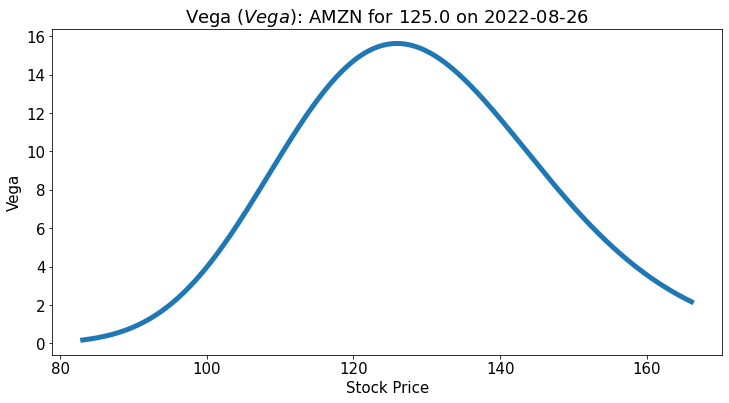

In [13]:
figtitle = f'Vega ($Vega$): {TICK} for {K} on {EXPRYDATE}'

dataplot = pd.Series(index=grid_px,dtype=float)
for spot in grid_px:
    dataplot.loc[spot] = bs_vega(under=spot,strike=K,T=tau,rf=rf,vol=ivolC)
    
dataplot.plot(ylabel='Vega',xlabel='Stock Price',title=figtitle,linewidth=5)
plt.show()

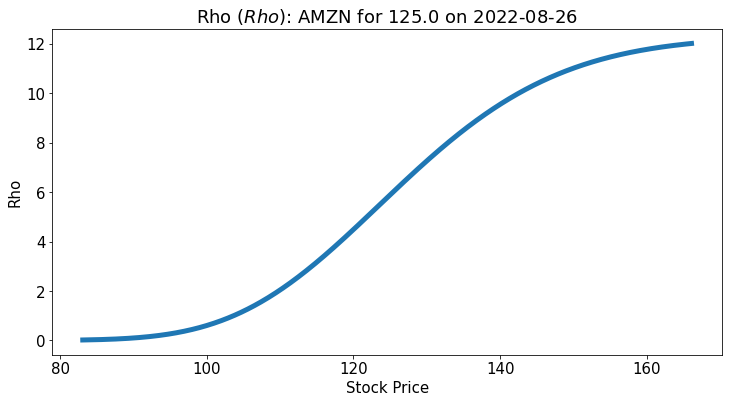

In [14]:
figtitle = f'Rho ($Rho$): {TICK} for {K} on {EXPRYDATE}'

dataplot = pd.Series(index=grid_px,dtype=float)
for spot in grid_px:
    dataplot.loc[spot] = bs_rho(under=spot,strike=K,T=tau,rf=rf,vol=ivolC)
    
dataplot.plot(ylabel='Rho',xlabel='Stock Price',title=figtitle,linewidth=5)
plt.show()

### Example

In [15]:
K0 = K

px_fields = ['lastPrice']

idx_call = (calls['strike']==K0).idxmax()
idx_put = (puts['strike']==K0).idxmax()

p_call = calls.loc[idx_call,px_fields].mean()
p_put = puts.loc[idx_put,px_fields].mean()

temp = [p_call-p_put, px-K0, px-K0*disc]
tab_bounds_american = pd.DataFrame(data=temp, index=['call - put', 'lower bound', 'upper bound'],columns=[f'{TICK}, {EXPRYDATE}, {K}']).T
tab_bounds_american.style.format('{:,.2f}')

,call - put,lower bound,upper bound
"AMZN, 2022-08-26, 125.0",-0.17,-0.37,-0.08


### Put-call parity

Put-Call parity implies that a call and put with equal strikes have equal implied volatilities.

In [16]:
imp_vol = pd.DataFrame(columns=tab_bounds_american.index, index = ['call','put'], data=[calls.loc[calls['strike']==K0,'impliedVolatility'].values[0], puts.loc[puts['strike']==K0,'impliedVolatility'].values[0]]).T
imp_vol.style.format('{:.2%}')

,call,put
"AMZN, 2022-08-26, 125.0",44.37%,42.65%


***

# Appendix

## Size of Markets

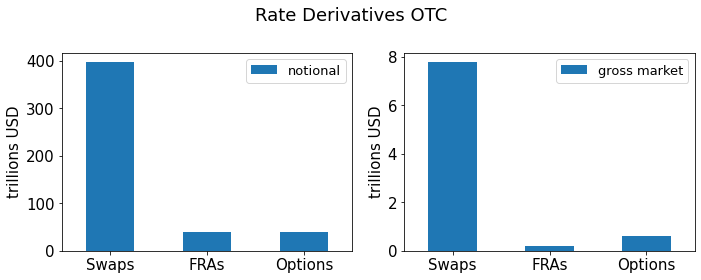

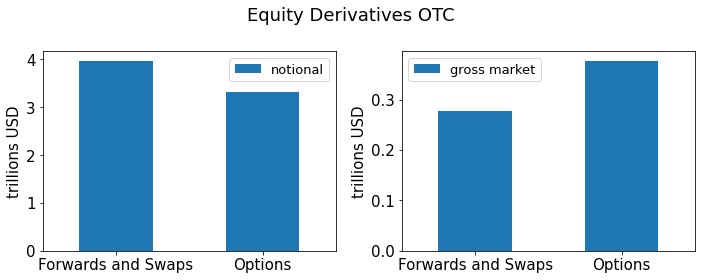

In [17]:
bis_rates = pd.DataFrame(index=['Swaps','FRAs','Options'],data=[397109,39438,38562],columns=['notional'])
bis_rates['gross market'] = [7787,195,630]
bis_eqty = pd.DataFrame(index=['Forwards and Swaps','Options'],data=[3968,3312],columns=['notional'])
bis_eqty['gross market'] = [278,377]

bis_rates /= 1000
bis_eqty /= 1000

fig,ax = plt.subplots(1,2,figsize=(10,4))
bis_rates[['notional']].plot.bar(ax=ax[0],ylabel='trillions USD')
bis_rates[['gross market']].plot.bar(ax=ax[1],ylabel='trillions USD')

ax[0].tick_params(axis='x',rotation=0)
ax[1].tick_params(axis='x',rotation=0)

plt.suptitle('Rate Derivatives OTC')
plt.tight_layout()
plt.show()

fig,ax = plt.subplots(1,2,figsize=(10,4))
bis_eqty[['notional']].plot.bar(ax=ax[0],ylabel='trillions USD')
bis_eqty[['gross market']].plot.bar(ax=ax[1],ylabel='trillions USD')

ax[0].tick_params(axis='x',rotation=0)
ax[1].tick_params(axis='x',rotation=0)

plt.suptitle('Equity Derivatives OTC')
plt.tight_layout()
plt.show()

## Black Scholes Derivation

### A Sketch of the Black-Scholes Proof via Replication

Recall that we have

$\begin{align}
\Pi_t =& f(S_t) - \beta_t S_t \\[5pt]
\beta_t =& \frac{\partial f}{\partial S}(S_t)\\[5pt]
\alpha_t =& \frac{f(S_t) - \beta_t S_t}{B_t}
\end{align}$

Then to satisfy no-arbitrage, the differential of this riskless portfolio must equal a process with expected growth rate of $r$ and zero risk:

$d\Pi_t = r\Pi_t dt$

Yet, via direct differentiation of $\Pi_t$ using 
- the assumed geometric Brownian motion for $S_t$, 
- Ito's Lemma

the drift of $d\Pi_t$ is
$$\left(\frac{\partial f}{\partial t} + \frac{1}{2}\frac{\partial^2 f}{\partial S^2}\sigma^2S^2\right)dt$$

So we have a drift of $d\Pi_t$ via the no-arbitrage argument and seemingly another via differentiation. The two drifts must be equal. Thus,
$$
r\Pi_t = \frac{\partial f}{\partial t} + \frac{1}{2}\sigma^2 S^2\frac{\partial^2 f}{\partial S^2}
$$

Finally,
$$
rf = \frac{\partial f}{\partial t} + rS\frac{\partial f}{\partial S} + \frac{1}{2}\sigma^2 S^2\frac{\partial^2 f}{\partial S^2}
$$

This is the fundamental derivative pricing equation.
- A function describes some derivative's no-arbitrage price if and only if it solves that differential equation.
- The derivative contract specifies the boundary condition, $f(S_T)$, which together with the fundamental equation above, defines the solution, $f(S_t)$.

## References

Reference: CBOE

https://www.cboe.com/us/options/market_statistics/#current

Reference: Bank of International Settlements

https://stats.bis.org/statx/srs/table/d5.1

Reference CME material on options

https://www.cmegroup.com/education/courses/introduction-to-options/introduction-to-options.html